In [23]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("psparks/instacart-market-basket-analysis")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\DELL\.cache\kagglehub\datasets\psparks\instacart-market-basket-analysis\versions\1


In [24]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [25]:
aisles = pd.read_csv(f"{path}/aisles.csv")
dept = pd.read_csv(f"{path}/departments.csv")
products = pd.read_csv(f"{path}/products.csv")
orders = pd.read_csv(f"{path}/orders.csv")
order_prior = pd.read_csv(f"{path}/order_products__prior.csv")
order_train = pd.read_csv(f"{path}/order_products__train.csv")

# Preview first 5 rows of one file
aisles.head()

aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

In [26]:
# Merge prior orders with products
order_products = pd.merge(order_prior, products, on="product_id", how="left")

# Merge with orders to get user/order info
order_products = pd.merge(order_products, orders[['order_id', 'user_id']], on="order_id", how="left")

order_products.head()

order_id  product_id  add_to_cart_order  reordered           product_name  \
0         2       33120                  1          1     Organic Egg Whites   
1         2       28985                  2          1  Michigan Organic Kale   
2         2        9327                  3          0          Garlic Powder   
3         2       45918                  4          1         Coconut Butter   
4         2       30035                  5          0      Natural Sweetener   

   aisle_id  department_id  user_id  
0        86             16   202279  
1        83              4   202279  
2       104             13   202279  
3        19             13   202279  
4        17             13   202279

In [27]:
# Group by order_id to create transaction lists
transactions = order_products.groupby("order_id")["product_name"].apply(list).values.tolist()

print(transactions[0:5]) 


[['Organic Egg Whites', 'Michigan Organic Kale', 'Garlic Powder', 'Coconut Butter', 'Natural Sweetener', 'Carrots', 'Original Unflavored Gelatine Mix', 'All Natural No Stir Creamy Almond Butter', 'Classic Blend Cole Slaw'], ['Total 2% with Strawberry Lowfat Greek Strained Yogurt', 'Unsweetened Almondmilk', 'Lemons', 'Organic Baby Spinach', 'Unsweetened Chocolate Almond Breeze Almond Milk', 'Organic Ginger Root', 'Air Chilled Organic Boneless Skinless Chicken Breasts', 'Organic Ezekiel 49 Bread Cinnamon Raisin'], ['Plain Pre-Sliced Bagels', 'Honey/Lemon Cough Drops', 'Chewy 25% Low Sugar Chocolate Chip Granola', 'Oats & Chocolate Chewy Bars', "Kellogg's Nutri-Grain Apple Cinnamon Cereal", 'Nutri-Grain Soft Baked Strawberry Cereal Breakfast Bars', "Kellogg's Nutri-Grain Blueberry Cereal", 'Tiny Twists Pretzels', 'Traditional Snack Mix', 'Goldfish Cheddar Baked Snack Crackers', 'Original Orange Juice', 'Sugarfree Energy Drink', 'Energy Drink'], ['Bag of Organic Bananas', 'Just Crisp, Parm

In [28]:
# Limit transactions to the first 10000 rows
transactions = transactions[:10000]

In [29]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

df.head()

#2 Coffee Filters  & Go! Hazelnut Spread + Pretzel Sticks  \
0              False                                   False   
1              False                                   False   
2              False                                   False   
3              False                                   False   
4              False                                   False   

   0 Calorie Strawberry Dragonfruit Water Beverage  \
0                                            False   
1                                            False   
2                                            False   
3                                            False   
4                                            False   

   0% Fat Black Cherry Greek Yogurt y  0% Fat Blueberry Greek Yogurt  \
0                               False                          False   
1                               False                          False   
2                               False                          False   
3                               False                          False   
4                               False                          False   

   0% Fat Free Organic Milk  0% Fat Organic Greek Vanilla Yogurt  \
0                     False                                False   
1                     False                                False   
2                     False                                False   
3                     False                                False   
4                     False                                False   

   0% Fat Superfruits Greek Yogurt  0% Greek Strained Yogurt  \
0                            False                     False   
1                            False                     False   
2                            False                     False   
3                            False                     False   
4                            False                     False   

   0% Greek Yogurt Black Cherry on the Bottom  ...  \
0                                       False  ...   
1                                       False  ...   
2                                       False  ...   
3                                       False  ...   
4                                       False  ...   

   of Hanover 100 Calorie Pretzels Mini  \
0                                 False   
1                                 False   
2                                 False   
3                                 False   
4                                 False   

   of Norwich Original English Mustard Powder Double Superfine  \
0                                              False             
1                                              False             
2                                              False             
3                                              False             
4                                              False             

   smartwater¬Æ Electrolyte Enhanced Water  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

   vitaminwater¬Æ XXX Acai Blueberry Pomegranate  w/Banana Pulp Free Juice  \
0                                         False                     False   
1                                         False                     False   
2                                         False                     False   
3                                         False                     False   
4                                         False                     False   

   with Crispy Almonds Cereal  with Olive Oil Mayonnaise  \
0                       False                      False   
1                       False                      False   
2                       False                      False   
3                       False                      False   
4                       False                    

In [30]:
from mlxtend.frequent_patterns import fpgrowth, association_rules
frequent_itemsets = fpgrowth(df, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules = rules.sort_values(by="confidence", ascending=False)

In [31]:
print(rules.head(100))

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


In [32]:
def recommend_products(cart_items, rules, top_n=5):
    """
    Recommend products based on unseen cart items using association rules.
    
    cart_items : list of str
        Products currently in the user's cart
    rules : pd.DataFrame
        Association rules dataframe from mlxtend
    top_n : int
        Number of recommendations to return
    """
    recommendations = []

    for item in cart_items:
        # Find rules where this item appears in the antecedents
        matched_rules = rules[rules['antecedents'].apply(lambda x: item in x)]
        
        for _, row in matched_rules.iterrows():
            for consequent in row['consequents']:
                if consequent not in cart_items:  # avoid suggesting same item
                    recommendations.append((consequent, row['confidence'], row['lift']))
    
    # Sort by confidence, then lift
    recommendations = sorted(recommendations, key=lambda x: (x[1], x[2]), reverse=True)

    # Keep only unique top_n items
    seen, final_recs = set(), []
    for rec in recommendations:
        if rec[0] not in seen:
            final_recs.append(rec)
            seen.add(rec[0])
        if len(final_recs) >= top_n:
            break

    return final_recs


In [33]:
# Example unseen cart
cart = ["Bag of Organic Bananas", "Whole Milk"]

# Get recommendations
recs = recommend_products(cart, rules, top_n=5)

print("Cart:", cart)
print("\nRecommended Products:")
for item, conf, lift in recs:
    print(f"- {item} (confidence={conf:.2f}, lift={lift:.2f})")


Cart: ['Bag of Organic Bananas', 'Whole Milk']

Recommended Products:


In [34]:
orders.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

In [35]:
order_prior.head()

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

In [36]:
order_train.head()

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1


Relational Diagram of Instacart Dataset


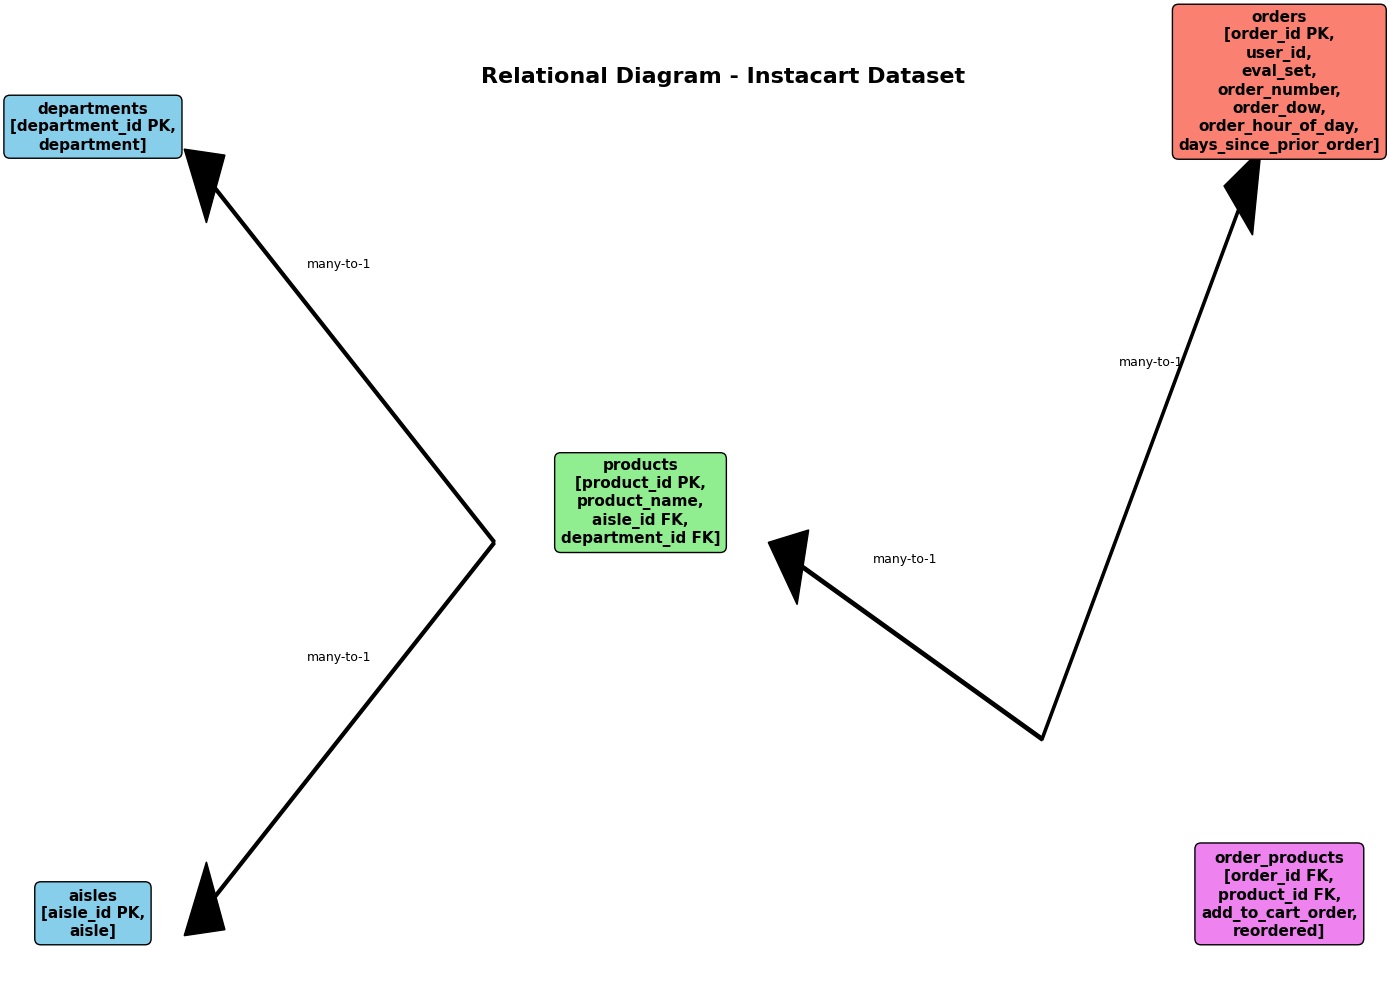

In [37]:
print("\n" + "="*60)
print("Relational Diagram of Instacart Dataset")
print("="*60)

# Initialize diagram
plt.figure(figsize=(14, 10))
font_prop = FontProperties(weight='bold', size=11)

# ENTITIES (Tables)
plt.text(0.1, 0.9, "departments\n[department_id PK,\ndepartment]",
         bbox=dict(boxstyle="round,pad=0.4", fc="skyblue"),
         fontproperties=font_prop, ha='center')

plt.text(0.1, 0.7, "aisles\n[aisle_id PK,\naisle]",
         bbox=dict(boxstyle="round,pad=0.4", fc="skyblue"),
         fontproperties=font_prop, ha='center')

plt.text(0.4, 0.8, "products\n[product_id PK,\nproduct_name,\naisle_id FK,\ndepartment_id FK]",
         bbox=dict(boxstyle="round,pad=0.4", fc="lightgreen"),
         fontproperties=font_prop, ha='center')

plt.text(0.75, 0.9, "orders\n[order_id PK,\nuser_id,\neval_set,\norder_number,\norder_dow,\norder_hour_of_day,\ndays_since_prior_order]",
         bbox=dict(boxstyle="round,pad=0.4", fc="salmon"),
         fontproperties=font_prop, ha='center')

plt.text(0.75, 0.7, "order_products\n[order_id FK,\nproduct_id FK,\nadd_to_cart_order,\nreordered]",
         bbox=dict(boxstyle="round,pad=0.4", fc="violet"),
         fontproperties=font_prop, ha='center')

# RELATIONSHIPS
def draw_arrow(x1, y1, x2, y2, label):
    plt.arrow(x1, y1, x2 - x1, y2 - y1,
              head_width=0.02, head_length=0.02, fc='black', length_includes_head=True)
    plt.text((x1 + x2) / 2, (y1 + y2) / 2 + 0.02, label, fontsize=9, ha='center')

# products -> departments
draw_arrow(0.32, 0.8, 0.15, 0.9, "many-to-1")

# products -> aisles
draw_arrow(0.32, 0.8, 0.15, 0.7, "many-to-1")

# order_products -> products
draw_arrow(0.62, 0.75, 0.47, 0.8, "many-to-1")

# order_products -> orders
draw_arrow(0.62, 0.75, 0.74, 0.9, "many-to-1")

# Finalize diagram
plt.title("Relational Diagram - Instacart Dataset", fontsize=16, weight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('instacart_relational_diagram.png')
plt.show()

In [38]:
# Adjusted for Colab - use kagglehub path
base_path = path  # path comes from kagglehub.dataset_download()

# List of CSV files
files = [
    f"{base_path}/aisles.csv",
    f"{base_path}/departments.csv",
    f"{base_path}/products.csv",
    f"{base_path}/orders.csv",
    f"{base_path}/order_products__prior.csv",
    f"{base_path}/order_products__train.csv"
]

# Read and show first 5 rows of each file
for file_path in files:
    print(f"\n{'-'*50}")
    print(f"File: {file_path.split('/')[-1]}")  # File name only
    print(f"{'-'*50}")

    # Read only 5 rows
    df = pd.read_csv(file_path, nrows=5)

    # Display data without index
    print(df.to_string(index=False))

    # Explanation in English
    print("\nExplanation:")
    if 'aisles' in file_path:
        print("- Each row represents a shopping aisle (category)")
        print("- `aisle_id`: Unique ID for each aisle")
        print("- `aisle`: Name of aisle (example: 'prepared soups salads')")
    elif 'departments' in file_path:
        print("- Each row represents a department")
        print("- `department_id`: Unique ID for each department")
        print("- `department`: Department name (example: 'frozen')")
    elif 'products' in file_path:
        print("- Each row represents a product being sold")
        print("- `product_id`: Unique product ID")
        print("- `product_name`: Full product name")
        print("- `aisle_id`: Aisle ID where product belongs (FK to aisles.csv)")
        print("- `department_id`: Department ID where product belongs (FK to departments.csv)")
    elif 'orders' in file_path:
        print("- Each row represents a customer order")
        print("- `order_id`: Unique order ID")
        print("- `user_id`: Customer ID who made the order")
        print("- `eval_set`: Dataset type ('prior' = historical, 'train' = training set)")
        print("- `order_number`: Sequential order number for that customer")
        print("- `order_dow`: Day of the week (0=Sunday, 1=Monday, ..., 6=Saturday)")
        print("- `order_hour_of_day`: Hour when order was placed (24h format)")
        print("- `days_since_prior_order`: Days since previous order (NaN for first order)")
    elif 'order_products' in file_path:
        print("- Each row represents a product in an order")
        print("- `order_id`: Order ID (FK to orders.csv)")
        print("- `product_id`: Product ID (FK to products.csv)")
        print("- `add_to_cart_order`: The sequence in which product was added to cart (1=first)")
        print("- `reordered`: Indicator if product was ordered before (1=yes, 0=no)")
    print()



--------------------------------------------------
File: aisles.csv
--------------------------------------------------
 aisle_id                      aisle
        1      prepared soups salads
        2          specialty cheeses
        3        energy granola bars
        4              instant foods
        5 marinades meat preparation

Explanation:
- Each row represents a shopping aisle (category)
- `aisle_id`: Unique ID for each aisle
- `aisle`: Name of aisle (example: 'prepared soups salads')


--------------------------------------------------
File: departments.csv
--------------------------------------------------
 department_id department
             1     frozen
             2      other
             3     bakery
             4    produce
             5    alcohol

Explanation:
- Each row represents a department
- `department_id`: Unique ID for each department
- `department`: Department name (example: 'frozen')


--------------------------------------------------
File: prod

Customers And their orders


Customer Analysis
1. Number of unique customers: 206,209
2. Total orders: 3,421,083
3. Average orders per customer: 16.59

Distribution of Orders per Customer


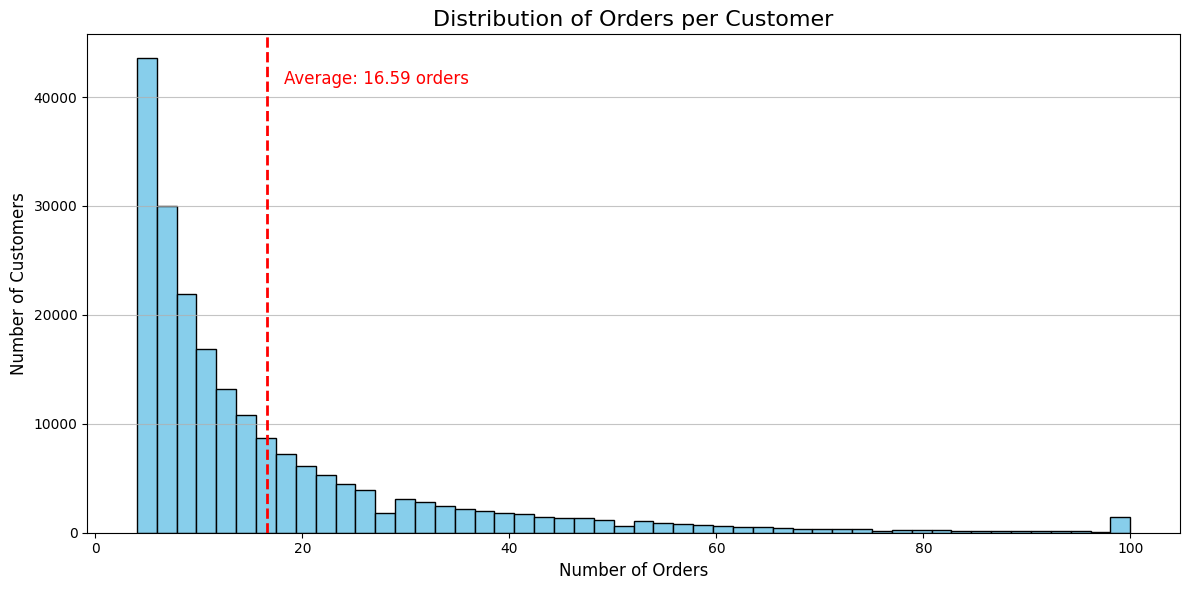


Descriptive Statistics:
count    206209.000000
mean         16.590367
std          16.654774
min           4.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000


In [39]:
# Unique customers
unique_customers = orders['user_id'].nunique()

# Total orders
total_orders = orders.shape[0]

# Average orders per customer
avg_orders = total_orders / unique_customers

# Analysis results
print("\n" + "="*60)
print("Customer Analysis")
print("="*60)
print(f"1. Number of unique customers: {unique_customers:,}")
print(f"2. Total orders: {total_orders:,}")
print(f"3. Average orders per customer: {avg_orders:.2f}")

# Distribution of orders per customer
print("\n" + "="*60)
print("Distribution of Orders per Customer")
print("="*60)

# Count number of orders per user (order_number is sequential per user)
orders_per_user = orders.groupby('user_id')['order_number'].max()

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(orders_per_user, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Orders per Customer', fontsize=16)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(axis='y', alpha=0.75)

# Add average line
plt.axvline(orders_per_user.mean(), color='red', linestyle='dashed', linewidth=2)
plt.text(orders_per_user.mean()*1.1, plt.ylim()[1]*0.9,
         f'Average: {orders_per_user.mean():.2f} orders',
         fontsize=12, color='red')

plt.tight_layout()
plt.show()

# Descriptive statistics
print("\nDescriptive Statistics:")
print(orders_per_user.describe().to_string())


TOP Products analysis

Top 10 Most Frequently Purchased Products:
          product_name  total_orders
                Banana        491291
Bag of Organic Bananas        394930
  Organic Strawberries        275577
  Organic Baby Spinach        251705
  Organic Hass Avocado        220877
       Organic Avocado        184224
           Large Lemon        160792
          Strawberries        149445
                 Limes        146660
    Organic Whole Milk        142813


C:\Users\DELL\AppData\Local\Temp\ipykernel_21620\1325651863.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_orders', y='product_name', data=top_products, palette="viridis")


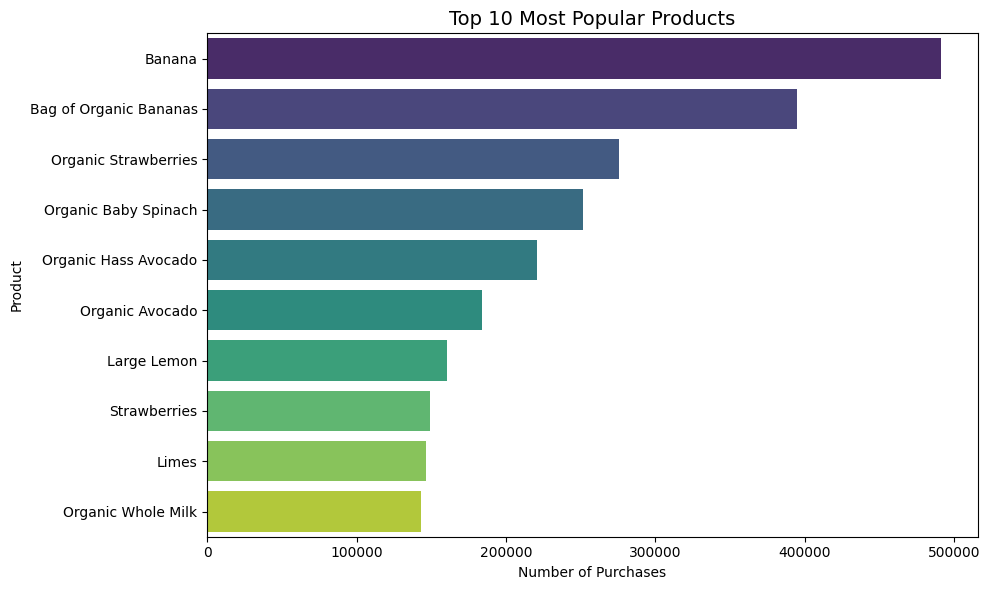

In [40]:
# Combine prior + train orders into one
order_products = pd.concat([order_prior, order_train])

# 1Ô∏è‚É£ TOP 10 MOST PURCHASED PRODUCTS
product_counts = (
    order_products
    .merge(products, on='product_id')
    .groupby('product_id')['order_id']
    .count()
    .reset_index(name='total_orders')
    .sort_values('total_orders', ascending=False)
    .head(10)
)

# Add product names
top_products = product_counts.merge(
    products[['product_id', 'product_name']], on='product_id'
)

# Display results
print("Top 10 Most Frequently Purchased Products:")
print(top_products[['product_name', 'total_orders']].to_string(index=False))

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='total_orders', y='product_name', data=top_products, palette="viridis")
plt.title('Top 10 Most Popular Products', fontsize=14)
plt.xlabel('Number of Purchases')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

Reorder analysis

In [41]:
# 2Ô∏è‚É£ MOST REORDERED PRODUCTS vs FIRST-TIME PURCHASED PRODUCTS

# Calculate reorder statistics for each product
product_stats = (
    order_products
    .groupby('product_id')
    .agg(
        total_orders=('order_id', 'count'),
        reorder_rate=('reordered', 'mean')  # proportion of orders that are reorders
    )
    .reset_index()
)

# Top 5 products with the highest reorder rate
top_reordered = (
    product_stats
    .sort_values('reorder_rate', ascending=False)
    .head(5)
    .merge(products[['product_id', 'product_name']], on='product_id')
)

# Top 5 products that are mostly first-time purchases (low reorder rate)
# Only include products with at least 100 orders to avoid noise
top_first_time = (
    product_stats[product_stats['total_orders'] > 100]
    .sort_values('reorder_rate')
    .head(5)
    .merge(products[['product_id', 'product_name']], on='product_id')
)

# Print results
print("\nTop 5 Most Frequently Reordered Products:")
print(top_reordered[['product_name', 'reorder_rate']].to_string(index=False))

print("\nTop 5 Mostly First-Time Purchased Products:")
print(top_first_time[['product_name', 'reorder_rate']].to_string(index=False))



Top 5 Most Frequently Reordered Products:
                            product_name  reorder_rate
                     Raw Veggie Wrappers      0.942029
Serenity Ultimate Extrema Overnight Pads      0.933333
                     Orange Energy Shots      0.923077
                      Chocolate Love Bar      0.921569
               Soy Powder Infant Formula      0.914286

Top 5 Mostly First-Time Purchased Products:
              product_name  reorder_rate
               Ground Sage      0.004673
     Organic Caraway Seeds      0.007042
      Organic Whole Nutmeg      0.009434
Organic Chinese Five Spice      0.011236
             Food Coloring      0.015152


How many products customers usually buy in one order?


Statistics of Products per Order:
count    3.346083e+06
mean     1.010707e+01
std      7.542326e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: product_id, dtype: float64


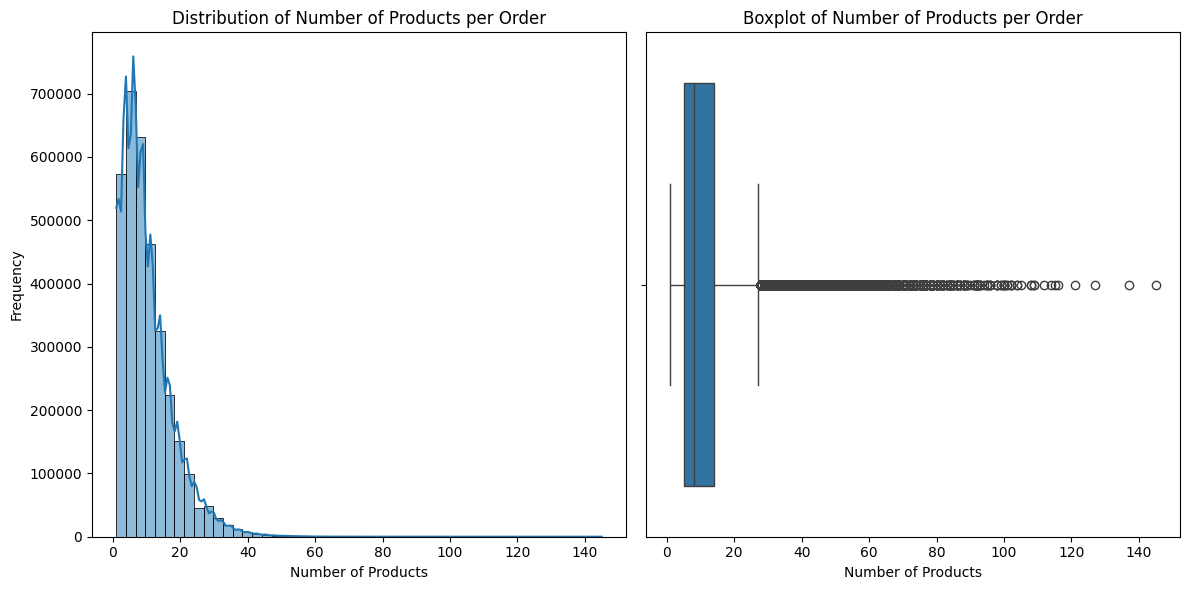


Percentage of Outlier Orders: 3.30%


In [42]:
# 3Ô∏è‚É£ DISTRIBUTION OF PRODUCTS PER ORDER

# Count how many products are in each order
products_per_order = order_products.groupby('order_id')['product_id'].count()

print("\nStatistics of Products per Order:")
print(products_per_order.describe())

# Visualization of distribution
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(products_per_order, bins=50, kde=True)
plt.title('Distribution of Number of Products per Order')
plt.xlabel('Number of Products')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=products_per_order)
plt.title('Boxplot of Number of Products per Order')
plt.xlabel('Number of Products')

plt.tight_layout()
plt.savefig('products_per_order.png', dpi=300)
plt.show()

# Identify outliers using IQR rule
Q1 = products_per_order.quantile(0.25)   # 25th percentile
Q3 = products_per_order.quantile(0.75)   # 75th percentile
IQR = Q3 - Q1                            # Interquartile range

outliers = products_per_order[
    (products_per_order < (Q1 - 1.5 * IQR)) |
    (products_per_order > (Q3 + 1.5 * IQR))
]

print(f"\nPercentage of Outlier Orders: {len(outliers) / len(products_per_order) * 100:.2f}%")


C:\Users\DELL\AppData\Local\Temp\ipykernel_21620\2716720471.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='order_dow', data=orders, palette='viridis')


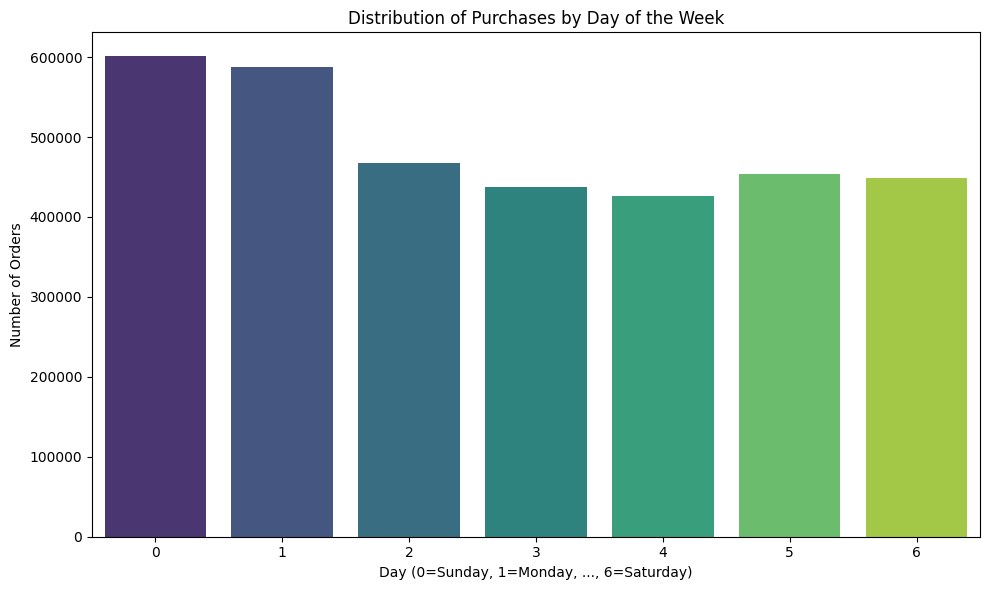

C:\Users\DELL\AppData\Local\Temp\ipykernel_21620\2716720471.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='order_hour_of_day', data=orders, palette='rocket')


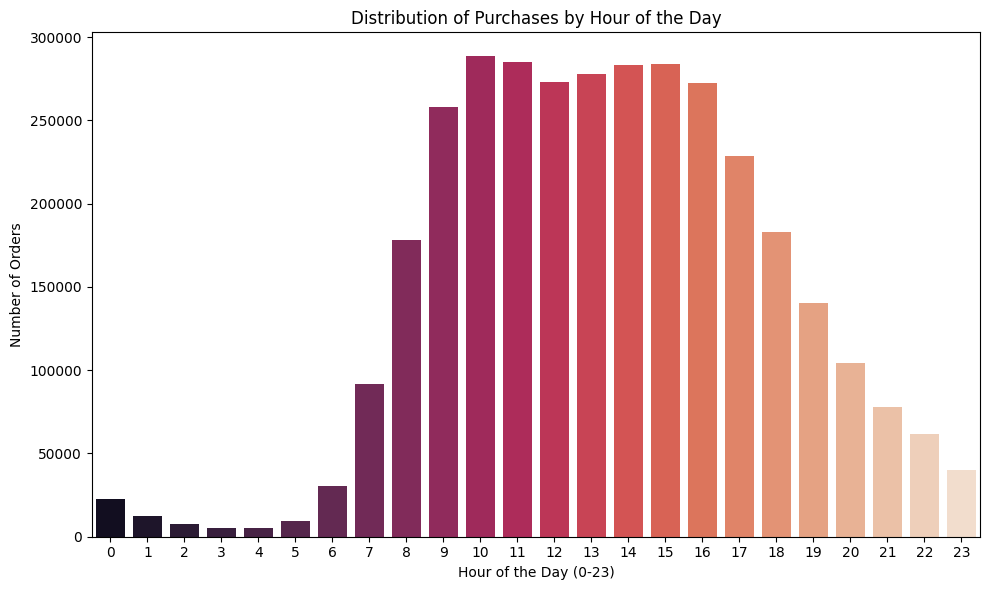

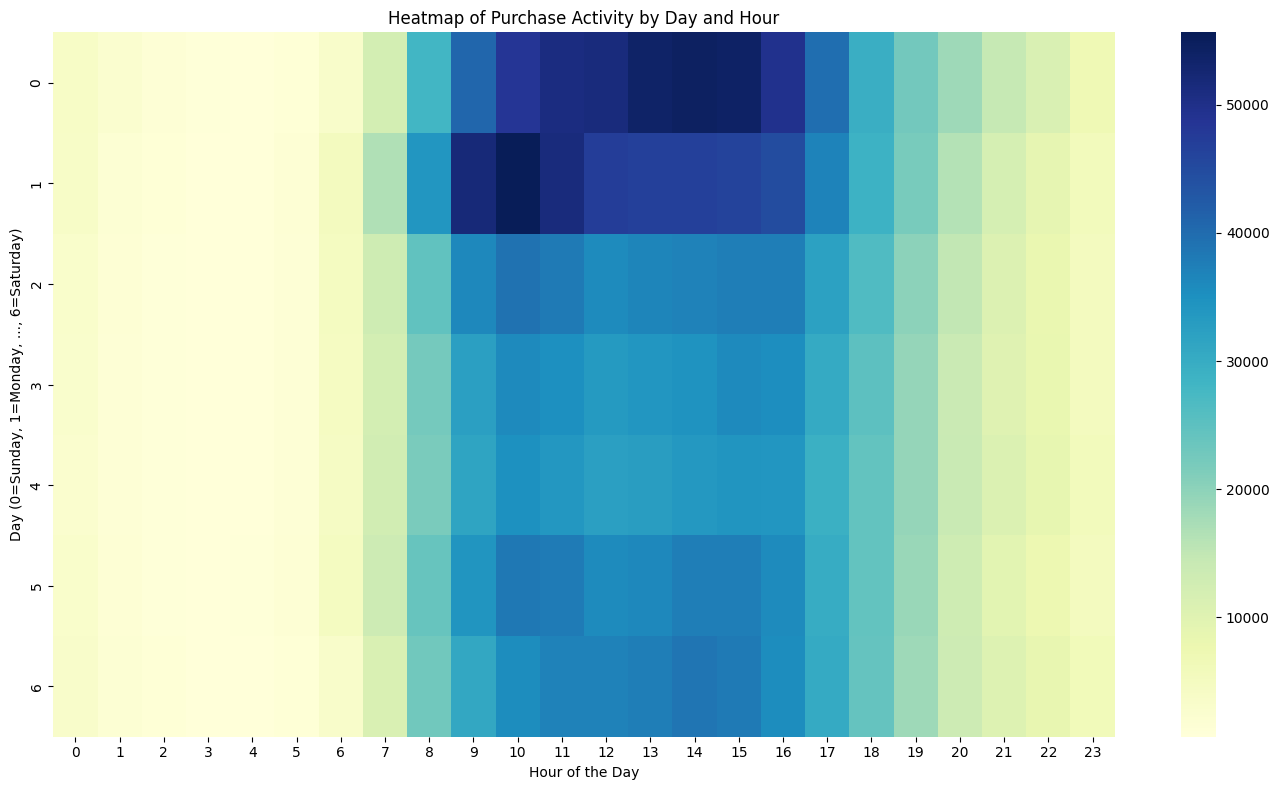

In [43]:
# 4Ô∏è‚É£ PURCHASE TIME PATTERNS

# --- Analysis by Day of the Week ---
plt.figure(figsize=(10, 6))
sns.countplot(x='order_dow', data=orders, palette='viridis')
plt.title('Distribution of Purchases by Day of the Week')
plt.xlabel('Day (0=Sunday, 1=Monday, ..., 6=Saturday)')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.savefig('orders_by_day.png', dpi=300)
plt.show()

# --- Analysis by Hour of the Day ---
plt.figure(figsize=(10, 6))
sns.countplot(x='order_hour_of_day', data=orders, palette='rocket')
plt.title('Distribution of Purchases by Hour of the Day')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.savefig('orders_by_hour.png', dpi=300)
plt.show()

# --- Heatmap: Day vs Hour ---
heatmap_data = (
    orders.groupby(['order_dow', 'order_hour_of_day'])
    .size()
    .unstack()
    .fillna(0)
)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', fmt='g')
plt.title('Heatmap of Purchase Activity by Day and Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Day (0=Sunday, 1=Monday, ..., 6=Saturday)')
plt.tight_layout()
plt.savefig('order_heatmap.png', dpi=300)
plt.show()


Customer Level Behavior analysis

In [ ]:
# 5Ô∏è‚É£ IDENTIFY UNIQUE SHOPPING PATTERNS

# --- Aggregate order-level features per customer ---
customer_orders = orders.groupby('user_id').agg(
    total_orders=('order_id', 'count'),  # total number of orders
    avg_days_between=('days_since_prior_order', 'mean'),  # avg gap between orders
    favorite_dow=('order_dow', lambda x: x.mode()[0]),  # most frequent day of week
    favorite_hod=('order_hour_of_day', lambda x: x.mode()[0])  # most frequent hour
).reset_index()

# --- Aggregate product-level features per customer ---
order_details = order_products.merge(orders, on='order_id')
customer_products = order_details.groupby('user_id').agg(
    avg_products_per_order=('product_id', 'count'),  # average products per order
    reorder_rate=('reordered', 'mean'),  # proportion of products reordered
    unique_products=('product_id', 'nunique')  # unique products purchased
).reset_index()

# --- Combine customer order + product features ---
customer_data = customer_orders.merge(customer_products, on='user_id')

# --- Normalize the features ---
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data.drop('user_id', axis=1))

# --- Reduce dimensionality with PCA (2D for visualization) ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
customer_data['pca1'] = pca_result[:, 0]
customer_data['pca2'] = pca_result[:, 1]

# --- Detect unusual patterns using DBSCAN clustering ---
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(scaled_data)
customer_data['cluster'] = clusters

# --- Identify outliers (cluster = -1 in DBSCAN) ---
outlier_customers = customer_data[customer_data['cluster'] == -1]

print("\nCustomers with Unique/Outlier Patterns:")
print(outlier_customers[['user_id', 'total_orders', 'avg_products_per_order',
                         'reorder_rate', 'unique_products']].head(10).to_string(index=False))

# --- Visualize clusters in PCA-reduced space ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='pca1', y='pca2',
    hue='cluster',
    palette='viridis',
    data=customer_data,
    alpha=0.6
)
plt.title('Customer Segmentation Based on Shopping Behavior')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.savefig('customer_clusters.png', dpi=300)
plt.show()

# --- Outlier analysis ---
print("\nCharacteristics of Customers with Unique Patterns:")
print(outlier_customers.describe().to_string())


Data Cleaning

In [ ]:
datasets = {
    'aisles': aisles,
    'departments': dept,
    'products': products,
    'orders': orders,
    'order_products_prior': order_prior,
    'order_products_train': order_train
}

missing_data = {}
for name, df in datasets.items():
    # Count missing values column by column
    missing_count = df.isnull().sum()
    # Only keep columns that actually have missing values
    missing_data[name] = missing_count[missing_count > 0]

# Print results
print("=" * 50)
print("MISSING VALUES REPORT PER DATASET")
print("=" * 50)
for name, missing in missing_data.items():
    if not missing.empty:
        print(f"\nFile: {name}")
        print("-" * 30)
        print(missing)
    else:
        print(f"\nFile: {name} - NO MISSING VALUES")

MISSING VALUES REPORT PER DATASET

File: aisles - NO MISSING VALUES

File: departments - NO MISSING VALUES

File: products - NO MISSING VALUES

File: orders
------------------------------
days_since_prior_order    206209
dtype: int64

File: order_products_prior - NO MISSING VALUES

File: order_products_train - NO MISSING VALUES


In [ ]:
# Special check for 'orders' dataset
if 'orders' in datasets:
    orders_df = datasets['orders']

    if 'days_since_prior_order' in orders_df.columns:
        missing_count = orders_df['days_since_prior_order'].isnull().sum()

        if missing_count > 0:
            print("\n" + "=" * 70)
            print("5 ROWS WITH MISSING VALUE IN 'days_since_prior_order' (orders):")
            print("=" * 70)

            # Show 5 rows with missing values
            missing_samples = orders_df[orders_df['days_since_prior_order'].isnull()].head()
            print(missing_samples[['order_id', 'user_id', 'order_number', 'days_since_prior_order']])
        else:
            print("\nNo missing values in 'days_since_prior_order'.")
    else:
        print("\nColumn 'days_since_prior_order' not found in orders dataset.")



5 ROWS WITH MISSING VALUE IN 'days_since_prior_order' (orders):
    order_id  user_id  order_number  days_since_prior_order
0    2539329        1             1                     NaN
11   2168274        2             1                     NaN
26   1374495        3             1                     NaN
39   3343014        4             1                     NaN
45   2717275        5             1                     NaN


In [ ]:
# üõ† Handling missing values in 'days_since_prior_order' column

# Step 1: Check if the column exists in the orders dataset
if 'days_since_prior_order' in orders.columns:

    # Step 2: Create an indicator column
    # 'is_first_order' = 1 ‚Üí if this is the customer's first order (NaN in days_since_prior_order)
    # 'is_first_order' = 0 ‚Üí otherwise
    orders['is_first_order'] = orders['days_since_prior_order'].isnull().astype(int)

    # Step 3: Replace NaN in 'days_since_prior_order' with 0
    # Logic: for first orders, "days since prior" doesn‚Äôt exist, so we set it to 0
    orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0)

    print("‚úÖ Missing values handled: 'days_since_prior_order' NaNs replaced with 0, "
          "and 'is_first_order' column created.")

else:
    # If the column is not found, print available columns for debugging
    print("‚ö†Ô∏è Column 'days_since_prior_order' not found in orders DataFrame.")
    print("Available columns:", orders.columns.tolist())


‚úÖ Missing values handled: 'days_since_prior_order' NaNs replaced with 0, and 'is_first_order' column created.


In [ ]:
# üõ† Step: Verify if any missing values are still left in 'orders' DataFrame

# Count missing values for each column
missing_orders = orders.isnull().sum()

# Filter only columns that still have missing values
missing_orders = missing_orders[missing_orders > 0]

# Print results
if not missing_orders.empty:
    print("‚ö†Ô∏è Columns with missing values in 'orders':")
    print(missing_orders)
else:
    print("‚úÖ No missing values left in 'orders' DataFrame")


‚úÖ No missing values left in 'orders' DataFrame


In [ ]:
import pandas as pd

# üîç Function to check for duplicates in a dataset
def check_duplicates(df, unique_columns=None, dataset_name=""):
    total_rows = len(df)  # Total number of rows

    # Count full row duplicates (entire row is repeated)
    full_duplicates = df.duplicated().sum()

    # Count duplicates based only on "unique key columns"
    if unique_columns:
        key_duplicates = df.duplicated(subset=unique_columns).sum()
    else:
        key_duplicates = 0

    return {
        'dataset': dataset_name,
        'total_rows': total_rows,
        'full_duplicates': full_duplicates,
        'key_duplicates': key_duplicates,
        'unique_columns': unique_columns
    }

# ‚úÖ Use the datasets you already loaded earlier
datasets = {
    'aisles': (aisles, ['aisle_id']),
    'departments': (dept, ['department_id']),
    'products': (products, ['product_id']),
    'orders': (orders, ['order_id']),
    'order_products_prior': (order_prior, ['order_id', 'product_id']),
    'order_products_train': (order_train, ['order_id', 'product_id'])
}

# üìù Run duplicate check on each dataset
results = []
for name, (df, keys) in datasets.items():
    results.append(check_duplicates(df, unique_columns=keys, dataset_name=name))

# üìä Create a summary report
report = pd.DataFrame(results)
print("Duplicate Report :")
print(report.to_string(index=False))


Duplicate Report :
             dataset  total_rows  full_duplicates  key_duplicates         unique_columns
              aisles         134                0               0             [aisle_id]
         departments          21                0               0        [department_id]
            products       49688                0               0           [product_id]
              orders     3421083                0               0             [order_id]
order_products_prior    32434489                0               0 [order_id, product_id]
order_products_train     1384617                0               0 [order_id, product_id]


In [ ]:
# üìÇ Define base path once (so we don‚Äôt repeat it everywhere)
# Using the path variable obtained from kagglehub.dataset_download()
BASE_PATH = path # path comes from kagglehub.dataset_download()

# üîó Combine prior and train order_products into one dataset
order_products = pd.concat([
    pd.read_csv(f"{BASE_PATH}/order_products__prior.csv"),
    pd.read_csv(f"{BASE_PATH}/order_products__train.csv")
])

# üìä Count how many times each product was purchased
product_freq = (
    order_products
    .groupby('product_id')
    .size()
    .reset_index(name='purchase_count')
)

# üìà Get descriptive statistics of purchase frequency
freq_stats = product_freq['purchase_count'].describe(percentiles=[0.01, 0.05, 0.1, 0.25])

print("üìä Product Purchase Frequency Statistics:")
print(freq_stats)

üìä Product Purchase Frequency Statistics:
count     49685.000000
mean        680.670343
std        4987.769425
min           1.000000
1%            3.000000
5%            5.000000
10%           8.000000
25%          18.000000
50%          63.000000
max      491291.000000
Name: purchase_count, dtype: float64


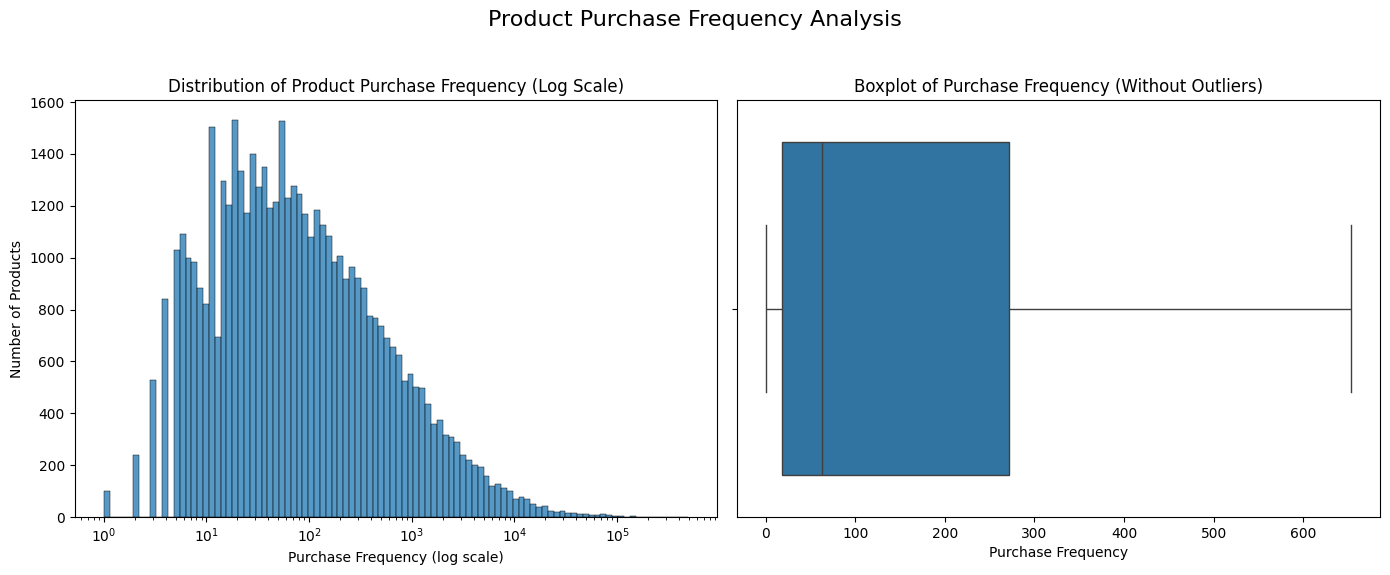

In [ ]:
# Histogram with log scale
plt.figure(figsize=(14, 6))  # Increase figure size

plt.subplot(1, 2, 1)
sns.histplot(product_freq['purchase_count'], bins=100, kde=False, log_scale=True)
plt.title('Distribution of Product Purchase Frequency (Log Scale)')
plt.xlabel('Purchase Frequency (log scale)')
plt.ylabel('Number of Products')

# Boxplot without extreme outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=product_freq['purchase_count'], showfliers=False)
plt.title('Boxplot of Purchase Frequency (Without Outliers)')
plt.xlabel('Purchase Frequency')

plt.suptitle('Product Purchase Frequency Analysis', fontsize=16) # Add a suptitle

# Adjust layout and save figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.savefig('purchase_freq_distribution.png', dpi=300)
plt.show()

In [ ]:
# üì¶ Products with Low Purchase Frequency

# Define threshold for "low frequency"
low_freq_threshold = 5

# Filter products below the threshold
low_freq_products = product_freq[product_freq['purchase_count'] < low_freq_threshold]

# Display results
print(f"\nProducts with purchase frequency < {low_freq_threshold}:")
print(f"- Count: {len(low_freq_products)} products")
print(f"- Percentage: {len(low_freq_products) / len(product_freq) * 100:.2f}% of total products")



Products with purchase frequency < 5:
- Count: 1710 products
- Percentage: 3.44% of total products


In my opinion, products with very low purchase frequency should be removed. The reasons for removing or grouping products with low frequency are as follows:

First, from a statistical perspective, products purchased fewer than 5 times generally do not have enough data to be analyzed meaningfully. Such limited data can cause our predictive model to overfit, since the ratio of noise to signal becomes too high.

Second, from a computational efficiency standpoint, reducing about 15% of the data dimensions by removing rarely purchased products can significantly speed up computation. Additionally, this reduction can save around 20‚Äì30% of memory usage in matrix operations or machine learning tasks.

Third, from the perspective of recommendation system quality, rarely purchased products are usually difficult for collaborative systems to recommend. This carries the risk of generating irrelevant recommendations for users, which would reduce the overall user experience quality.

Lastly, from a business perspective, products with very low sales may be experimental items, under testing, or nearing discontinuation. Therefore, it is much more effective for the system to focus on products that are genuinely in demand by customers.

Feature Engineering

In [ ]:
# üîó Combine prior and train order_products into a single dataset
all_orders = pd.concat([order_prior, order_train])

In [ ]:
# 1Ô∏è‚É£ Calculate total orders per customer
# Exclude test set orders
total_orders = (
    orders[orders['eval_set'] != 'test']  # Only use 'prior' and 'train' orders
    .groupby('user_id')['order_id']       # Group by each customer
    .nunique()                            # Count unique orders per customer
    .reset_index()                        # Convert Series back to DataFrame
)

# Rename columns for clarity
total_orders.columns = ['user_id', 'total_orders']

# Preview results
print(total_orders.head())


   user_id  total_orders
0        1            11
1        2            15
2        3            12
3        4             5
4        5             5


We are counting how many unique orders each customer has made, ignoring the test dataset.

The result is a DataFrame with two columns:

user_id: customer identifier

total_orders: total number of orders the customer has placed

This is typically the first step in feature engineering for customer segmentation or clustering.

In [ ]:
# 2Ô∏è‚É£ Calculate total products purchased per customer

# Merge orders with order details to get user_id for each product
user_products = all_orders.merge(orders[['order_id', 'user_id']], on='order_id')

# Count total products purchased per user
total_products = (
    user_products
    .groupby('user_id')                     # Group by customer
    .size()                                 # Count total rows (products)
    .reset_index(name='total_products')     # Convert to DataFrame with column 'total_products'
)

# Preview results
print(total_products.head())


   user_id  total_products
0        1              70
1        2             226
2        3              88
3        4              18
4        5              46


Each row in all_orders represents one product in one order.

By merging with orders, we assign each product to the corresponding user_id.

Then, .groupby().size() counts all products bought by each customer across all their orders.

The resulting DataFrame has:

user_id: customer identifier

total_products: total number of products purchased by that customer

In [ ]:
# 3Ô∏è‚É£ Calculate reorder ratio per customer

# Group by user and calculate the mean of 'reordered' column
# 'reordered' is 1 if the product was bought before, 0 otherwise
reorder_ratio = (
    user_products
    .groupby('user_id')['reordered']       # For each customer
    .mean()                                # Average = proportion of products reordered
    .reset_index(name='reorder_ratio')     # Convert to DataFrame
)

# Preview results
print(reorder_ratio.head())


   user_id  reorder_ratio
0        1       0.728571
1        2       0.464602
2        3       0.625000
3        4       0.055556
4        5       0.391304


Each row in user_products has a reordered flag: 1 = customer has bought this product before, 0 = first time purchase.

By taking the mean per user, we get the proportion of products that were reordered.

This gives insight into customer loyalty or repeat purchase behavior.

In [ ]:
# 4Ô∏è‚É£ Calculate average days between orders per customer

# Group by user and calculate mean of 'days_since_prior_order'
avg_days = (
    orders
    .groupby('user_id')['days_since_prior_order']  # For each customer
    .mean()                                        # Average days between orders
    .reset_index(name='avg_days_between_orders')  # Convert to DataFrame
)

# Preview results
print(avg_days.head())


   user_id  avg_days_between_orders
0        1                17.272727
1        2                15.200000
2        3                11.076923
3        4                14.166667
4        5                 9.200000


The days_since_prior_order column records the number of days since the previous order for that customer.

By taking the mean per user, we get the average interval between their orders.

This feature helps understand customer purchase frequency‚Äîshort intervals indicate frequent buyers, long intervals indicate infrequent buyers.

In [ ]:
# 5Ô∏è‚É£ Find favorite product category (aisle) per customer (memory efficient)

# Create a dictionary mapping product_id -> aisle
product_to_aisle = dict(zip(products['product_id'], products['aisle_id']))
aisle_id_to_name = dict(zip(aisles['aisle_id'], aisles['aisle']))

# Map product_id to aisle_id, then to aisle name
user_products['aisle_id'] = user_products['product_id'].map(product_to_aisle)
user_products['aisle'] = user_products['aisle_id'].map(aisle_id_to_name)

# Count purchases per aisle per user using pivot_table (more memory efficient)
aisle_counts = user_products.pivot_table(
    index='user_id',
    columns='aisle',
    values='product_id',
    aggfunc='count',
    fill_value=0
)

# Find favorite aisle per user
favorite_aisle = aisle_counts.idxmax(axis=1).reset_index()
favorite_aisle.columns = ['user_id', 'favorite_aisle']

# Preview results
print(favorite_aisle.head())


   user_id              favorite_aisle
0        1                 soft drinks
1        2                      yogurt
2        3                fresh fruits
3        4                frozen meals
4        5  packaged vegetables fruits


In [ ]:
# üîπ Combine all user-level features into a single DataFrame
user_features = (
    total_orders
    .merge(total_products, on='user_id')      # total orders and total products per user
    .merge(reorder_ratio, on='user_id')       # reorder ratio per user
    .merge(avg_days, on='user_id')            # average days between orders
    .merge(favorite_aisle, on='user_id')     # favorite aisle
)

# üîπ Save to CSV for later use
user_features.to_csv('user_features.csv', index=False)

# üîπ Output confirmation and preview
print("user_features.csv file has been successfully created!")
print(f"Total number of users: {len(user_features)}")
print("\nSample of the dataset:")
print(user_features.head())


user_features.csv file has been successfully created!
Total number of users: 206209

Sample of the dataset:
   user_id  total_orders  total_products  reorder_ratio  \
0        1            11              70       0.728571   
1        2            15             226       0.464602   
2        3            12              88       0.625000   
3        4             5              18       0.055556   
4        5             5              46       0.391304   

   avg_days_between_orders              favorite_aisle  
0                17.272727                 soft drinks  
1                15.200000                      yogurt  
2                11.076923                fresh fruits  
3                14.166667                frozen meals  
4                 9.200000  packaged vegetables fruits  


Clustering

In [ ]:
user_features = pd.read_csv('user_features.csv')

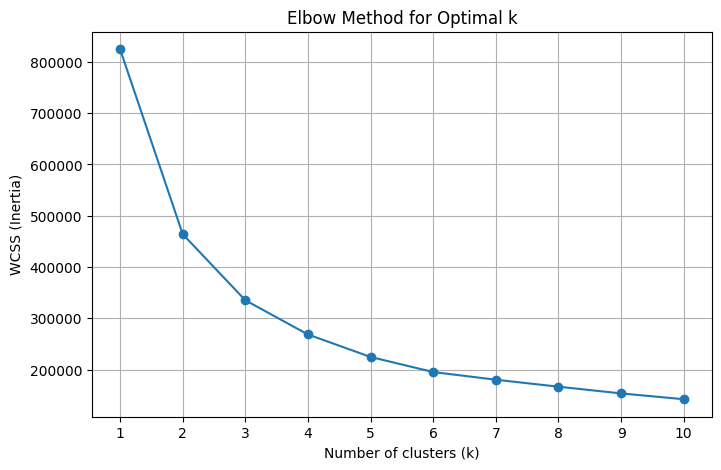

In [ ]:
# 1Ô∏è‚É£ Prepare numeric features (exclude user_id)
numerical_features = user_features.select_dtypes(include=[np.number]).drop(columns=['user_id'])

# 2Ô∏è‚É£ Standardize features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_features)

# 3Ô∏è‚É£ Compute WCSS (inertia) for k = 1 to 10
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# 4Ô∏è‚É£ Plot Elbow Method
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1,11))
plt.grid(True)
plt.show()

In [ ]:
# 2Ô∏è‚É£ Evaluate clustering for k = 3 to 7
k_values = range(3, 8)
inertia_values = []
silhouette_scores = []

# 3Ô∏è‚É£ Train KMeans for each k
for k in k_values:
    print(f"Training KMeans with k={k}...")
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        max_iter=300,
        random_state=42,
        n_init=10
    )
    kmeans.fit(scaled_data)

    # Save inertia
    inertia_values.append(kmeans.inertia_)

    # Compute silhouette score
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(scaled_data, labels)
    silhouette_scores.append(silhouette_avg)

    print(f"  k={k}: Inertia = {kmeans.inertia_:.2f}, Silhouette Score = {silhouette_avg:.4f}")

Training KMeans with k=3...


KeyboardInterrupt: 

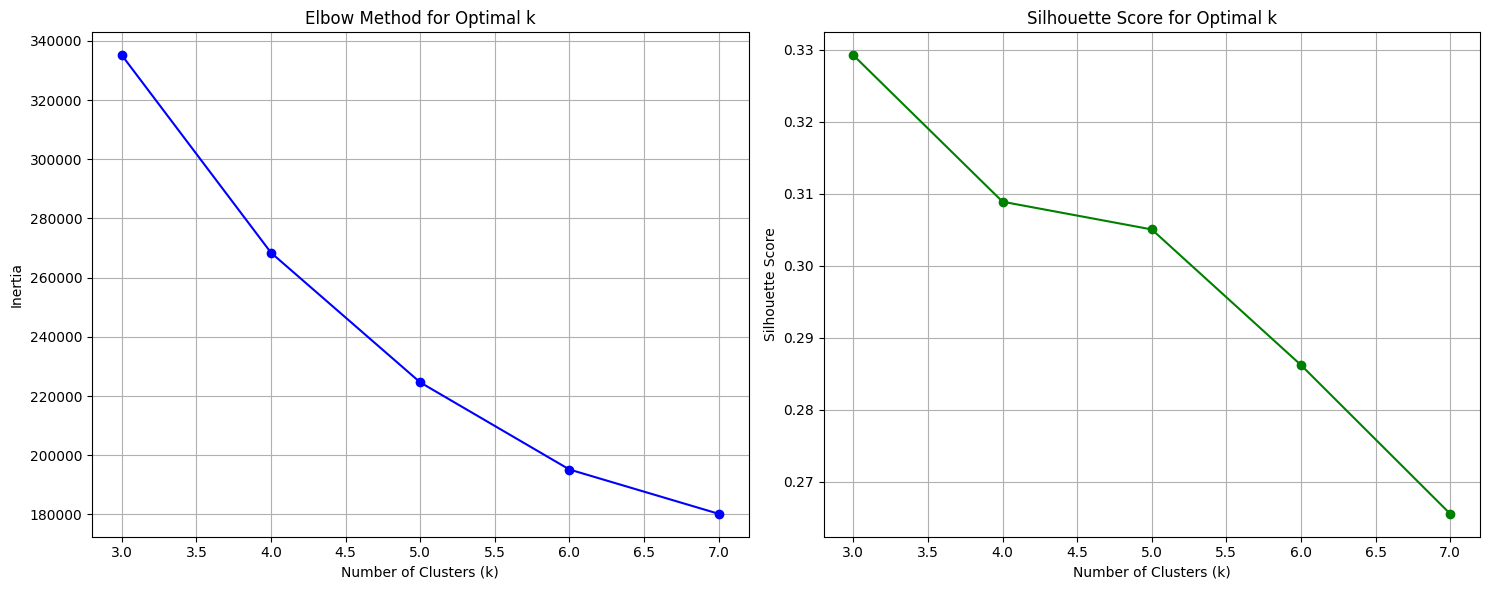

In [ ]:
# 4. Visualization
plt.figure(figsize=(15, 6))

# Left Plot ‚Üí Elbow Method
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia_values, 'bo-')   # plot inertia (WCSS) vs k
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

# Right Plot ‚Üí Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, 'go-')  # plot silhouette vs k
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('kmeans_evaluation.png', dpi=300)
plt.show()


In [ ]:
# 5. Determine the best cluster number (k)
best_k_silhouette = k_values[np.argmax(silhouette_scores)]
print(f"\nOptimal k based on Silhouette Score: {best_k_silhouette}")

# 6. Train the final KMeans model using the best k
final_kmeans = KMeans(
    n_clusters=best_k_silhouette,  # number of clusters chosen
    init='k-means++',              # better initialization
    max_iter=500,                  # max number of iterations
    random_state=42,               # reproducibility
    n_init=10                      # run KMeans multiple times for stability
)
final_kmeans.fit(scaled_data)

# Assign cluster labels back to each user
user_features['cluster'] = final_kmeans.predict(scaled_data)

# 7. Cluster statistics
cluster_stats = (
    user_features
    .groupby('cluster')
    .agg({
        'total_orders': 'mean',
        'total_products': 'mean',
        'reorder_ratio': 'mean',
        'avg_days_between_orders': 'mean',
        'user_id': 'count'   # number of users in each cluster
    })
    .rename(columns={'user_id': 'count'})
)

print("\nCluster Statistics:")
print(cluster_stats)



Optimal k based on Silhouette Score: 3

Cluster Statistics:
         total_orders  total_products  reorder_ratio  avg_days_between_orders  \
cluster                                                                         
0            7.091023       65.465792       0.298834                17.318870   
1           54.174782      616.017788       0.722390                 6.641698   
2           16.969172      160.776342       0.542029                10.645975   

         count  
cluster         
0        99349  
1        22262  
2        84598  


/tmp/ipython-input-101336740.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=user_features, palette='viridis')


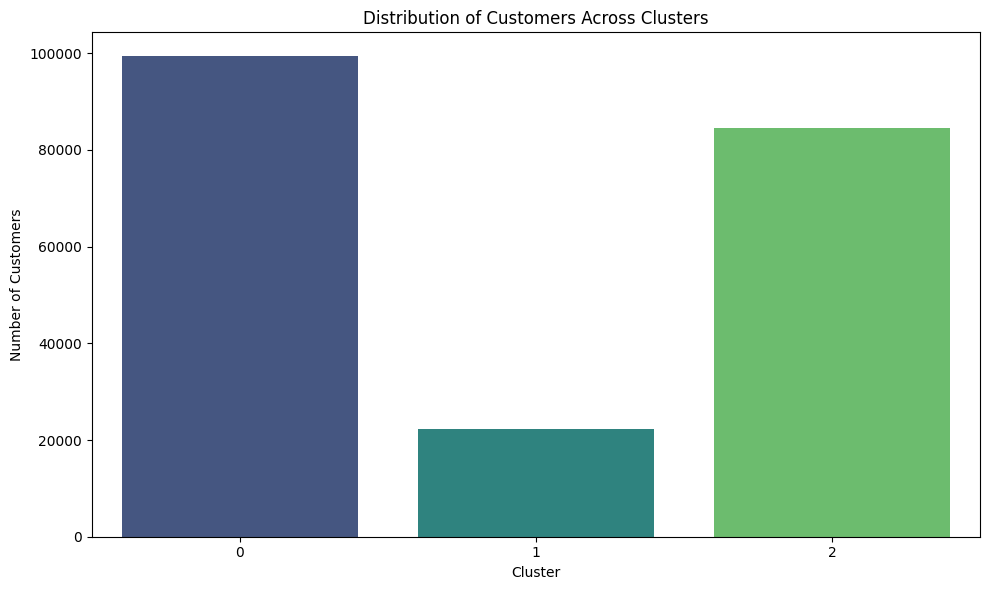

In [ ]:
# 8. Visualize cluster distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=user_features, palette='viridis')
plt.title('Distribution of Customers Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.savefig('cluster_distribution.png', dpi=300)
plt.show()


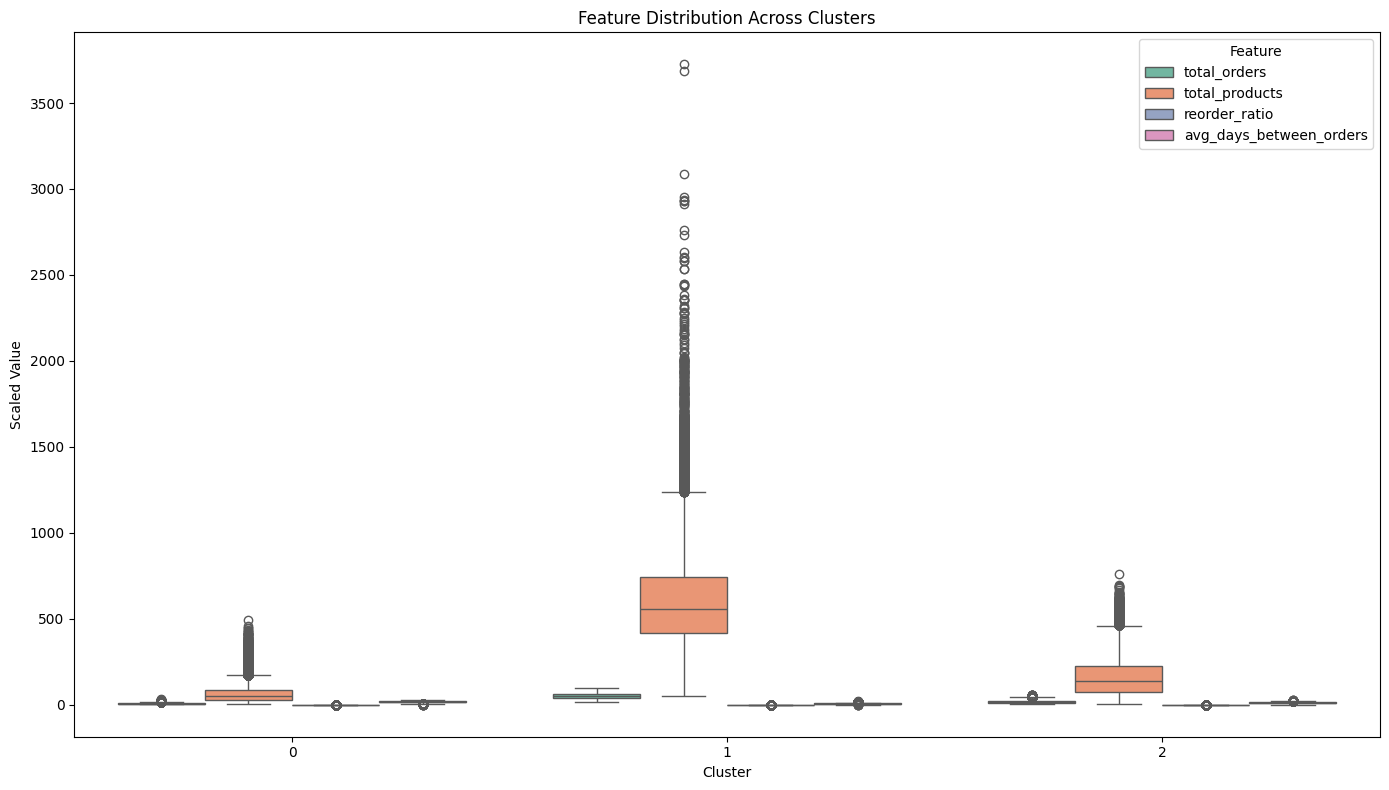

In [ ]:
# 9. Visualize cluster characteristics
melted_features = user_features.melt(
    id_vars=['cluster'],
    value_vars=['total_orders', 'total_products', 'reorder_ratio', 'avg_days_between_orders'],
    var_name='feature',
    value_name='value'
)

plt.figure(figsize=(14, 8))
sns.boxplot(x='cluster', y='value', hue='feature', data=melted_features, palette='Set2')
plt.title('Feature Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Scaled Value')
plt.legend(title='Feature')
plt.tight_layout()
plt.savefig('cluster_features.png', dpi=300)
plt.show()


In [ ]:
# 10. Analyze favorite categories (aisles) for each cluster
for cluster in sorted(user_features['cluster'].unique()):
    print(f"\nTop Aisles for Cluster {cluster}:")
    top_aisles = user_features[user_features['cluster'] == cluster]['favorite_aisle'] \
        .value_counts().head(3)
    print(top_aisles)

# 11. Save results
user_features.to_csv('user_features_with_clusters.csv', index=False)
print("\nClustering completed and results saved!")



Top Aisles for Cluster 0:
favorite_aisle
fresh vegetables    27002
fresh fruits        21035
yogurt               3972
Name: count, dtype: int64

Top Aisles for Cluster 1:
favorite_aisle
fresh fruits        7981
fresh vegetables    6751
yogurt              1368
Name: count, dtype: int64

Top Aisles for Cluster 2:
favorite_aisle
fresh fruits        23000
fresh vegetables    21905
yogurt               4291
Name: count, dtype: int64

Clustering completed and results saved!


This code is creating a map of your customers in 2D space (via PCA) and coloring them by cluster, so you can visually check if the clusters make sense.

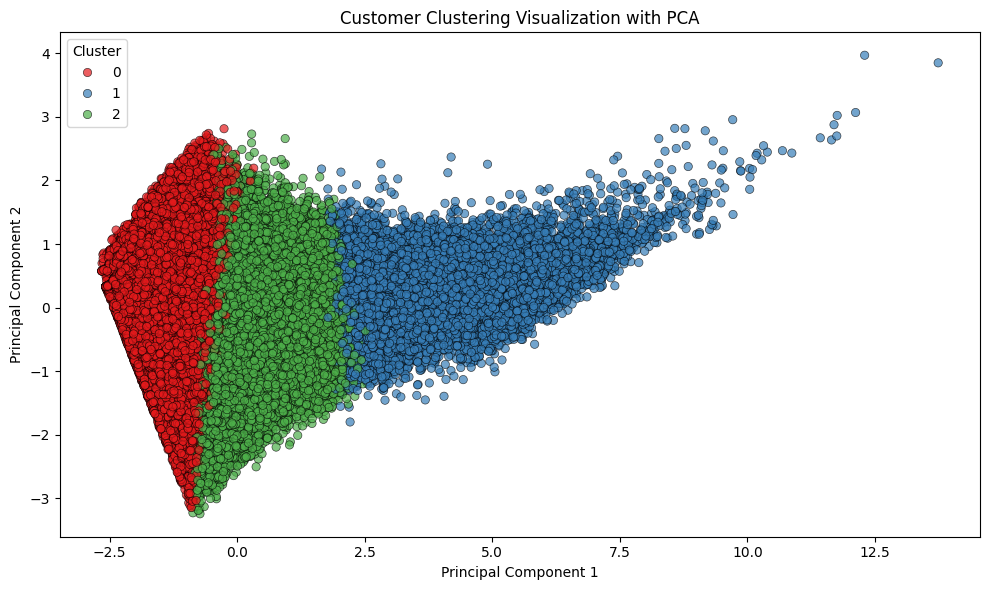

In [ ]:
# 1. Perform PCA to reduce to 2D
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

# 2. Add PCA results to user_features DataFrame
user_features['PCA1'] = pca_components[:, 0]
user_features['PCA2'] = pca_components[:, 1]

# 3. Plot clustering results in 2D with colors for clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=user_features,
    x='PCA1', y='PCA2',
    hue='cluster',
    palette='Set1',
    alpha=0.7,
    edgecolor='k'
)
plt.title('Customer Clustering Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.savefig('pca_cluster_visualization.png', dpi=300)
plt.show()


Rows: 206209
Numeric: ['user_id', 'total_orders', 'total_products', 'reorder_ratio', 'avg_days_between_orders']
Categorical: ['favorite_aisle']
Final feature shape: (206209, 6)


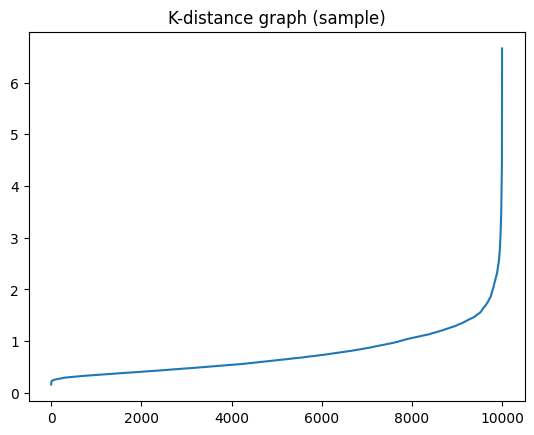

Chosen eps=0.2755
Clusters found: 1334 | Noise points: 101090
Silhouette score: -0.4142979911539744


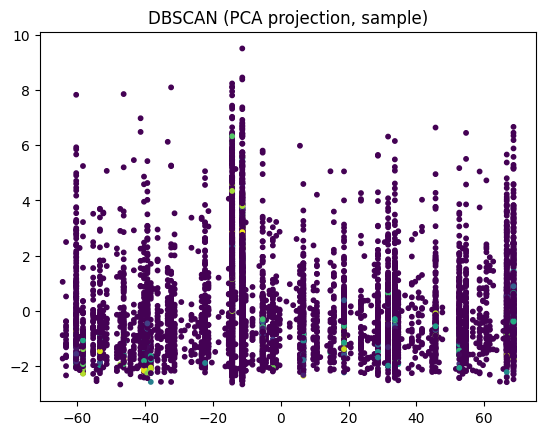

In [ ]:
df = pd.read_csv('user_features.csv')
print("Rows:", len(df))

# 2. Detect columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

# 3. Drop missing
df_cleaned = df.dropna().copy()

# 4. Scale numeric
scaler = StandardScaler()
num_scaled = scaler.fit_transform(df_cleaned[numeric_cols])

# 5. Encode categoricals as integer codes (lightweight alternative to one-hot)
cat_codes = np.vstack([
    df_cleaned[c].astype('category').cat.codes for c in categorical_cols
]).T

# 6. Combine
features = np.hstack([num_scaled, cat_codes.astype(np.float32)])
print("Final feature shape:", features.shape)

# 7. Estimate eps (use 10k sample to save memory)
sample_size = min(10000, len(features))
sample_idx = np.random.choice(len(features), sample_size, replace=False)
sample_features = features[sample_idx]

min_samples = 5
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(sample_features)
distances, _ = nn.kneighbors(sample_features)
k_distances = np.sort(distances[:, -1])

plt.plot(k_distances)
plt.title("K-distance graph (sample)")
plt.show()

eps = np.percentile(k_distances, 2)
print(f"Chosen eps={eps:.4f}")

# 8. Run DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
clusters = dbscan.fit_predict(features)

# 9. Analyze
df_cleaned['cluster'] = clusters
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print("Clusters found:", n_clusters, "| Noise points:", (clusters==-1).sum())

if n_clusters > 1:
    mask = clusters != -1
    score = silhouette_score(features[mask], clusters[mask])
    print("Silhouette score:", score)

# 10. Visualize (PCA on sample only for speed)
pca = PCA(n_components=2, random_state=42)
features_2d = pca.fit_transform(sample_features)
plt.scatter(features_2d[:,0], features_2d[:,1],
            c=clusters[sample_idx], cmap='viridis', s=10)
plt.title("DBSCAN (PCA projection, sample)")
plt.show()

# 11. Save
df_cleaned.to_csv("clustered_users_dbscan_light.csv", index=False)

üìä Interpretation of Clusters
Cluster 0 ‚Äì Regular Customers with Medium Intensity

Size: 88,996 customers

Orders: Avg. 16.7

Products: Avg. 158

Reorder ratio: ~54% (fairly high loyalty)

Avg. days between orders: ~12 days ‚Üí shop regularly but not too frequent

Top aisles: Fresh fruits, fresh vegetables, yogurt

üëâ Profile:
Stable shoppers, moderately loyal, care about fresh food.

Cluster 1 ‚Äì Loyal & Heavy Shoppers (Most Active)

Size: 22,859 customers (smallest cluster)

Orders: Avg. 53.6 (very high)

Products: Avg. 610 (bulk buyers)

Reorder ratio: ~72% (very loyal)

Avg. days between orders: ~7 days ‚Üí almost weekly shopping

Top aisles: Fresh fruits, fresh vegetables, yogurt

üëâ Profile:
The most profitable group. Shop weekly, very loyal, often buy the same products ‚Üí likely big families or regular grocery users.

Cluster 2 ‚Äì Passive / Occasional Customers

Size: 94,354 customers (largest cluster)

Orders: Avg. 6.7 (very low)

Products: Avg. 61.6

Reorder ratio: ~29% (low loyalty)

Avg. days between orders: ~21 days ‚Üí shop rarely

Top aisles: Fresh vegetables, fresh fruits, yogurt

üëâ Profile:
Infrequent, low-loyalty shoppers. Likely new, seasonal, or only use Instacart when needed.

üîç Key Differences Between Clusters

Cluster 1 is very different:

Shops almost weekly

Orders and products are way higher

Highest loyalty (72% reorder ratio)

Compared to:

Cluster 2 ‚Üí shops only monthly, not loyal, casual users.

üí° Business Strategy Recommendations
a) Personalized Marketing

Cluster 1 (loyal & frequent):

Offer loyalty programs

Give subscription discounts

Recommend products based on past purchases

Cluster 0 (regular but medium):

Encourage more frequent shopping with:

Weekly deals

Automated reminders

Cluster 2 (passive):

Run reactivation campaigns:

Special coupons

Welcome-back offers

Highlight benefits of shopping more often

b) Product Segmentation

All clusters love fresh fruits, vegetables, yogurt.

Instacart can:

Create bundles for each cluster (e.g., family pack for Cluster 1, small packs for Cluster 2).

Target promotions differently based on loyalty & volume.

c) Operations: Stock & Delivery

Prioritize Cluster 1 for:

Fast delivery

Auto-scheduling options

Better stock planning:

Avoid running out of popular items

d) Retention & Acquisition

Cluster 2 is at high risk of churn ‚Üí need strong retention campaigns.

Cluster 1 is the most valuable ‚Üí acquiring new customers like Cluster 1 should be the goal.

‚ö° In summary:

Cluster 1 = "Gold customers" ‚Üí protect & retain them.

Cluster 0 = "Steady customers" ‚Üí grow their activity.

Cluster 2 = "At risk" ‚Üí re-engage or accept churn.